## Ensemble Model Notebook

---

### Objective:

- Given the chosen sampling rate, extraction interval and selected filtered features, to investigate the potential benefit of an ensemble model.

### Methodology:

- Create 4 models using the following algorithms:
    - Random Forest
    - Gradient Boosting
    - XGBoost
    - LightGBM
    - MLP
- Train each model on the training data
- Take the most predicted class from each model
- Use the majority vote to make the final prediction

#### Findings:

Selected Features after the correlation analysis:


In [94]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score,balanced_accuracy_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

In [95]:
# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + 'raw/'

# Models
MODELS = "../../models/"
MODELS_RESULTS = MODELS + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "none"
RESULT_NAME = f"results_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
CM_ARTIFACT_NAME = f"confusion_matrix_models_comparison_artifact_recognition_{BALANCING_TYPE}.npy"
CM_DISEASE_NAME = (
    f"confusion_matrix_models_comparison_disease_recognition_{BALANCING_TYPE}.npy"
)

In [96]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = f'full_data_filtered_{INTERVAL}s_4000hz_' + '_'.join(numvalue for _, numvalue in num_feats.items()) + '.npy'
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data['train']['X'].shape[1]

### 1st model - Classification of artifacts, normal and abnormal

In [97]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------
MODELS = {'Random Forest': RandomForestClassifier(random_state=SEED),
        'XGBoost': XGBClassifier(random_state=SEED),
        'MLP': MLPClassifier(hidden_layer_sizes=(128, 64, 32,), activation='relu', solver='adam', random_state=SEED),
        'CatBoost': CatBoostClassifier(random_state=SEED, verbose=0),
        'LightGBM': LGBMClassifier(random_state=SEED)}

METRICS = {
    "Test Acc": accuracy_score,
    "Macro F1": f1_score,
    "Balanced Accuracy": balanced_accuracy_score,
}

result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(MODELS.keys()))
cm_dict = {}

Training Random Forest

Training XGBoost

Training MLP

Training CatBoost

Training LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10323
[LightGBM] [Info] Number of data points in the train set: 3904, number of used features: 41
[LightGBM] [Info] Start training from score -1.423877
[LightGBM] [Info] Start training from score -3.606318
[LightGBM] [Info] Start training from score -1.461822
[LightGBM] [Info] Start training from score -0.796688
[LightGBM] [Info] Start training from score -3.007067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


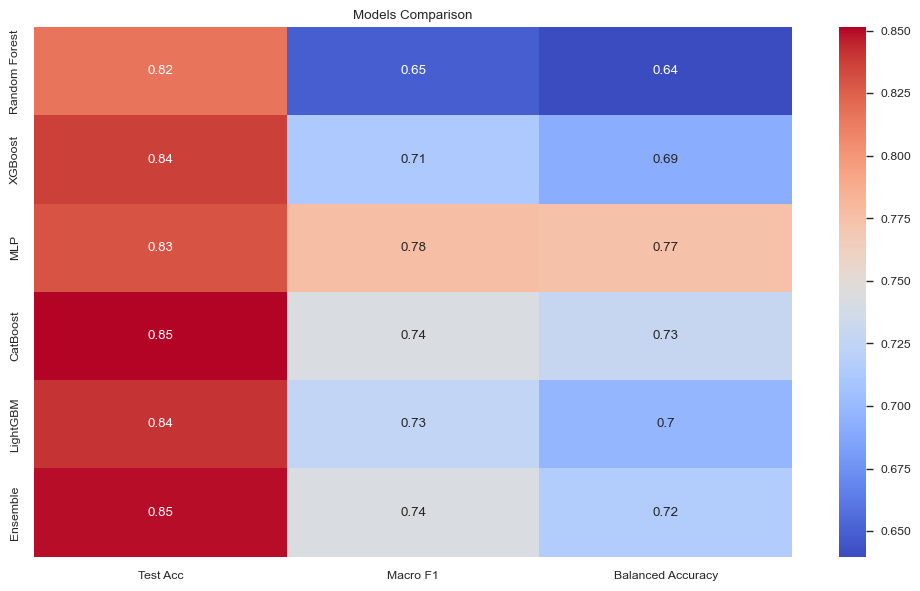

In [98]:
# train each model, store predictions and take the most predicted class as final perdiction
y_pred_all = np.zeros((full_data['test']['y'].shape[0], 1))
for model_name, model in MODELS.items():
	print(f"Training {model_name}\n")
	y_pred_local = []
	model.fit(full_data['train']['X'], full_data['train']['y'])
	y_pred = model.predict(full_data['test']['X'])
	y_pred_local.append(y_pred)
	y_true = full_data['test']['y']
	for metric_name, metric in METRICS.items():
		if 'macro' in metric_name.lower():
			result_df.loc[model_name, metric_name] = metric(y_true, y_pred, average='macro')
		else:
			result_df.loc[model_name, metric_name] = metric(y_true, y_pred)
	cm_dict[model_name] = confusion_matrix(y_true, y_pred)
 
	y_pred_all = np.hstack([y_pred_all, np.vstack(y_pred_local).reshape(-1,1)])

# drop the first column
y_pred_all = y_pred_all[:, 1:]

# take the most predicted class as final perdiction
y_pred_ensemble = []
for row in y_pred_all:
    y_pred_ensemble.append(np.argmax(np.bincount(row.astype(int))))
y_pred = np.array(y_pred_ensemble)
y_true = full_data['test']['y']
for metric_name, metric in METRICS.items():
	if 'macro' in metric_name.lower():
		result_df.loc['Ensemble', metric_name] = metric(y_true, y_pred, average='macro')
	else:
		result_df.loc['Ensemble', metric_name] = metric(y_true, y_pred)
cm_dict['Ensemble'] = confusion_matrix(y_true, y_pred)

# save the results
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)

# plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(result_df.astype(float), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Models Comparison')
plt.tight_layout()
plt.show()